In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import nltk
import spacy
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
import gensim
import nltk
from nltk.corpus import stopwords
from gensim import corpora
from gensim.corpora import Dictionary
from gensim.models.ldamodel import LdaModel
from gensim.models.coherencemodel import CoherenceModel
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

nltk.download('stopwords')  
nlp = spacy.load("en_core_web_sm")
nltk.download('punkt')

/usr/local/lib/python3.9/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# import os
# os.chdir('/content/drive/MyDrive/Colab Notebooks')

In [ ]:
doc = pd.read_csv("tweets.csv")

In [ ]:
doc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10001 entries, 0 to 10000
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   _id       10001 non-null  int64  
 1   username  10001 non-null  object 
 2   text      10001 non-null  object 
 3   qScore    10001 non-null  float64
 4   nScore    10001 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 390.8+ KB


## Cleaning

In [ ]:
doc.head()

,_id,username,text,qScore,nScore
0,1621600585291014145,realJackEason,@pansexualflower Criterion certainly have US r...,0.613271,2.934114
1,1621600584360153088,ManojKu40226010,🇨🇳 🇺🇸 #China\n#Chinese #Foreign #Ministry said...,0.446642,-2.994406
2,1621600585358233600,TansyWatts,“As they began to understand the children’s op...,0.609156,1.772004
3,1621600585391783943,Green_Man1984,Excess Deaths Skyrocket Again In England And W...,0.608929,-1.639187
4,1621600586020933632,bruis3pristin3,"@altgirlalterego scotland, seychelles, syria, ...",0.608089,-0.254614


In [ ]:
#remove the twitter handles
clean = []
for text in doc['text']:
  clean_tweet = re.sub(r'@\w+', '', text)
  clean.append(clean_tweet)
doc['clean_text'] = clean

In [ ]:
#remove special characters, numbers and punctuations
doc['clean_text'] = doc['clean_text'].str.replace("[^a-zA-Z]", " ")

<ipython-input-8-3cd66f1f5bd1>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  doc['clean_text'] = doc['clean_text'].str.replace("[^a-zA-Z]", " ")


In [ ]:
#using Spacy to remove all the spaces, punctuations and stopwords
#removing all the words that have a length less than 3 because tweets contain word such as rt, which is not required
def text_cleanup(text):
  tokens = []
  doc = nlp(text)
  for t in doc:
    if not t.is_stop and not t.is_punct and not  t.is_space and len(t) > 3:
      tokens.append(t.lemma_.lower())
  return ' '.join(tokens)

In [ ]:
filtered = []
for d in doc['clean_text']:
    processed_text = text_cleanup(d)
    filtered.append(processed_text)
doc['clean_text'] = filtered

In [ ]:
tokenized_text = doc['clean_text'].apply(lambda x: x.split())

In [ ]:
# Define a function to tokenize a piece of text
def tokenize_text(text):
    tokens = nltk.word_tokenize(text)
    return tokens

In [ ]:
doc['tokens'] = doc['clean_text'].apply(tokenize_text)

In [ ]:
# #removing any blank enteries
doc = doc[doc.clean_text!=""]
doc = doc[doc.clean_text!=" "]

In [ ]:
num_words = [len(sentence.split()) for sentence in doc['clean_text']]

In [ ]:
avg_words = sum(num_words)/len(num_words)

In [ ]:
doc.head()

,_id,username,text,qScore,nScore,clean_text,tokens
0,1621600585291014145,realJackEason,@pansexualflower Criterion certainly have US r...,0.613271,2.934114,criterion certainly right restoration unlikely...,"[criterion, certainly, right, restoration, unl..."
1,1621600584360153088,ManojKu40226010,🇨🇳 🇺🇸 #China\n#Chinese #Foreign #Ministry said...,0.446642,-2.994406,china chinese foreign ministry say weather bal...,"[china, chinese, foreign, ministry, say, weath..."
2,1621600585358233600,TansyWatts,“As they began to understand the children’s op...,0.609156,1.772004,begin understand child operational scheme purp...,"[begin, understand, child, operational, scheme..."
3,1621600585391783943,Green_Man1984,Excess Deaths Skyrocket Again In England And W...,0.608929,-1.639187,excess deaths skyrocket england wales death ex...,"[excess, deaths, skyrocket, england, wales, de..."
4,1621600586020933632,bruis3pristin3,"@altgirlalterego scotland, seychelles, syria, ...",0.608089,-0.254614,scotland seychelle syria south africa south korea,"[scotland, seychelle, syria, south, africa, so..."


## Basic Information

In [ ]:
print("Total number of words after tokenisation: ", sum(num_words))
print("Average number of words per tweet: ", avg_words)
print("The maximum number of words in a tweet: ", max(num_words))
print("The minimum number of words in a tweet: ", min(num_words))
print("The number of tweets: ", len(num_words))

Total number of words after tokenisation:  109000
Average number of words per tweet:  10.91091091091091
The maximum number of words in a tweet:  34
The minimum number of words in a tweet:  1
The number of tweets:  9990


## Topic modelling of tweets using LDA

In [ ]:
token = doc['tokens'].tolist()

In [ ]:
dictionary = corpora.Dictionary(token)
corpus = [dictionary.doc2bow(doc) for doc in token]

In [ ]:
def compute_coherence_score(corpus, dictionary, num_topics):
    lda_model = LdaModel(corpus=corpus,
                         id2word=dictionary,
                         num_topics=num_topics,
                         random_state=42,
                         passes=10,
                         )
    coherence_model = CoherenceModel(model=lda_model, corpus=corpus, dictionary=dictionary, coherence='c_v', texts = token)
    return coherence_model.get_coherence()


In [ ]:
coherence_scores = []
for num_topics in range(2, 21, 1):
    score = compute_coherence_score(corpus, dictionary, num_topics)
    coherence_scores.append(score)

In [ ]:
print('Coherence Scores:')
for num_topics, score in zip(range(2, 21, 1), coherence_scores):
    print('Num Topics = {}: Coherence Score = {}'.format(num_topics, round(score, 4))) 


Coherence Scores:
Num Topics = 2: Coherence Score = 0.262
Num Topics = 3: Coherence Score = 0.1962
Num Topics = 4: Coherence Score = 0.2259
Num Topics = 5: Coherence Score = 0.2641
Num Topics = 6: Coherence Score = 0.3107
Num Topics = 7: Coherence Score = 0.2659
Num Topics = 8: Coherence Score = 0.3091
Num Topics = 9: Coherence Score = 0.2863
Num Topics = 10: Coherence Score = 0.3249
Num Topics = 11: Coherence Score = 0.2989
Num Topics = 12: Coherence Score = 0.3325
Num Topics = 13: Coherence Score = 0.3186
Num Topics = 14: Coherence Score = 0.3586
Num Topics = 15: Coherence Score = 0.3624
Num Topics = 16: Coherence Score = 0.3731
Num Topics = 17: Coherence Score = 0.331
Num Topics = 18: Coherence Score = 0.3322
Num Topics = 19: Coherence Score = 0.3777
Num Topics = 20: Coherence Score = 0.3339


In [ ]:
optimal_num_topics = coherence_scores.index(max(coherence_scores)) + 2

In [ ]:
lda_model = LdaModel(corpus=corpus,
                     id2word=dictionary,
                     num_topics=optimal_num_topics,
                     random_state=42,
                     passes=10,
                     )

In [ ]:
print('LDA Model Topics:')
for idx, topic in lda_model.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

LDA Model Topics:
Topic: 0 
Words: 0.033*"https" + 0.016*"minister" + 0.015*"vote" + 0.013*"prime" + 0.012*"government" + 0.009*"say" + 0.009*"election" + 0.008*"conservatives" + 0.008*"labour" + 0.008*"fall"
Topic: 1 
Words: 0.035*"https" + 0.021*"long" + 0.021*"bear" + 0.019*"link" + 0.017*"book" + 0.017*"flight" + 0.015*"london" + 0.012*"hell" + 0.012*"live" + 0.010*"airport"
Topic: 2 
Words: 0.029*"https" + 0.012*"question" + 0.011*"dublin" + 0.010*"song" + 0.008*"small" + 0.008*"daily" + 0.008*"drop" + 0.007*"agree" + 0.006*"edinburgh" + 0.006*"huge"
Topic: 3 
Words: 0.036*"time" + 0.024*"united" + 0.023*"https" + 0.020*"manchester" + 0.015*"year" + 0.013*"lose" + 0.011*"london" + 0.010*"play" + 0.010*"good" + 0.009*"half"
Topic: 4 
Words: 0.022*"right" + 0.017*"https" + 0.015*"power" + 0.013*"happy" + 0.013*"go" + 0.009*"follow" + 0.009*"york" + 0.009*"know" + 0.008*"like" + 0.008*"people"
Topic: 5 
Words: 0.036*"https" + 0.020*"ticket" + 0.014*"sell" + 0.014*"london" + 0.010*"fa

In [ ]:
doc['topic'] = [max(lda_model.get_document_topics(bow), key=lambda x: x[1])[0] for bow in corpus]

In [ ]:
# Topic Distribution 
doc_topic_distr = []
for i in range(len(corpus)):
    bow = corpus[i]
    topic_distr = lda_model.get_document_topics(bow, minimum_probability=0.0)
    topic_distr = [(topic_id, prob) for topic_id, prob in topic_distr]
    doc_topic_distr.append(topic_distr)
print(doc_topic_distr)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



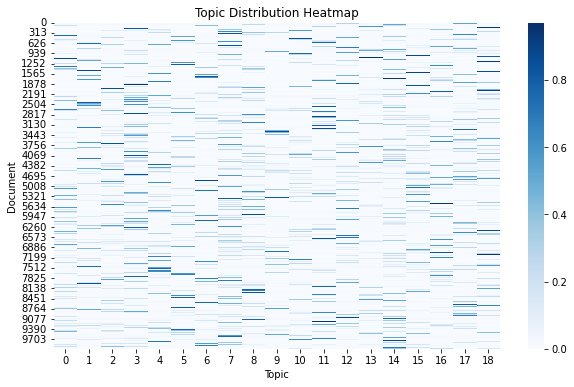

In [ ]:
topic_dist = [lda_model.get_document_topics(doc) for doc in corpus]

# Convert topic distribution to a numpy array
topic_dist_np = np.zeros((len(topic_dist), lda_model.num_topics))
for i, doc_topics in enumerate(topic_dist):
    for topic, prob in doc_topics:
        topic_dist_np[i, topic] = prob

# Generating the heatmap
fig, ax = plt.subplots(figsize=(10, 6))
sns.heatmap(topic_dist_np, cmap='Blues', ax=ax)
ax.set_xlabel('Topic')
ax.set_ylabel('Document')
ax.set_title('Topic Distribution Heatmap')
plt.show()

In [ ]:
topic_dist_np

array([[0.12552029, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.08190462],
       [0.        , 0.07700358, 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.07115522, 0.        , 0.        , ..., 0.        , 0.73210949,
        0.        ],
       [0.35757411, 0.01315789, 0.01315789, ..., 0.01315789, 0.0131579 ,
        0.01315789],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

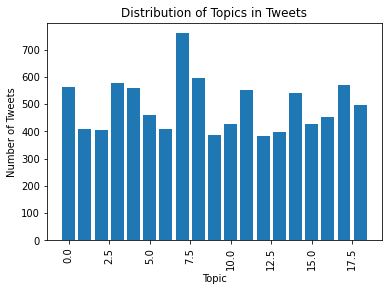

In [ ]:
#bar graph of topic distribution
topic_counts = np.sum(topic_dist_np, axis=0)
plt.bar(range(lda_model.num_topics), topic_counts)
plt.xticks(rotation=90)
plt.xlabel('Topic')
plt.ylabel('Number of Tweets')
plt.title('Distribution of Topics in Tweets')
plt.show()

## Grouped Tweets

In [ ]:
doc_g = pd.read_csv('groupedTweets.csv')

## Cleaning

In [ ]:
#remove the twitter handles
clean = []
for text in doc_g['text']:
  clean_tweet = re.sub(r'@\w+', '', text)
  clean.append(clean_tweet)
doc_g['clean_text'] = clean

In [ ]:
#remove special characters, numbers and punctuations
doc_g['clean_text'] = doc_g['clean_text'].str.replace("[^a-zA-Z]", " ")

<ipython-input-35-fcc79520a5e5>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  doc_g['clean_text'] = doc_g['clean_text'].str.replace("[^a-zA-Z]", " ")


In [ ]:
filtered = []
for d in doc_g['clean_text']:
    processed_text = text_cleanup(d)
    filtered.append(processed_text)
doc_g['clean_text'] = filtered

In [ ]:
# Define a function to concatenate text values
def concat_texts(texts):
    return ' '.join(texts)

# Group by 'group' column and apply custom function to concatenate text values
grouped_doc = doc_g.groupby('group')['clean_text'].agg(concat_texts).reset_index()

In [ ]:
grouped_doc

,group,clean_text
0,0,criterion certainly right restoration unlikely...
1,1,china chinese foreign ministry say weather bal...
2,2,begin understand child operational scheme purp...
3,3,excess deaths skyrocket england wales death ex...
4,4,scotland seychelle syria south africa south ko...
...,...,...
466,466,cool
467,467,mean ford ferrari
468,468,fucking split terminate cunt contract
469,469,graham potter start havertz aubameyang ludacris


In [ ]:
def tokenize_text(text):
    tokens = nltk.word_tokenize(text)
    return tokens

In [ ]:
grouped_doc['tokens'] = grouped_doc['clean_text'].apply(tokenize_text)

In [ ]:
grouped_doc

,group,clean_text,tokens
0,0,criterion certainly right restoration unlikely...,"[criterion, certainly, right, restoration, unl..."
1,1,china chinese foreign ministry say weather bal...,"[china, chinese, foreign, ministry, say, weath..."
2,2,begin understand child operational scheme purp...,"[begin, understand, child, operational, scheme..."
3,3,excess deaths skyrocket england wales death ex...,"[excess, deaths, skyrocket, england, wales, de..."
4,4,scotland seychelle syria south africa south ko...,"[scotland, seychelle, syria, south, africa, so..."
...,...,...,...
466,466,cool,[cool]
467,467,mean ford ferrari,"[mean, ford, ferrari]"
468,468,fucking split terminate cunt contract,"[fucking, split, terminate, cunt, contract]"
469,469,graham potter start havertz aubameyang ludacris,"[graham, potter, start, havertz, aubameyang, l..."


In [ ]:
#removing any blank enteries
grouped_doc = grouped_doc[grouped_doc.clean_text!=""]
grouped_doc = grouped_doc[grouped_doc.clean_text!=" "]

In [ ]:
num_words = [len(sentence.split()) for sentence in grouped_doc['clean_text']]

In [ ]:
avg_words = sum(num_words)/len(num_words)

## Statistics

In [ ]:
print("Total number of words after tokenisation: ", sum(num_words))
print("Average number of words per tweet: ", avg_words)
print("The maximum number of words in a tweet: ", max(num_words))
print("The minimum number of words in a tweet: ", min(num_words))
print("The number of tweets: ", len(num_words))

Total number of words after tokenisation:  108673
Average number of words per tweet:  231.71215351812367
The maximum number of words in a tweet:  12039
The minimum number of words in a tweet:  1
The number of tweets:  469


In [ ]:
grouped_doc

,group,clean_text,tokens
0,0,criterion certainly right restoration unlikely...,"[criterion, certainly, right, restoration, unl..."
1,1,china chinese foreign ministry say weather bal...,"[china, chinese, foreign, ministry, say, weath..."
2,2,begin understand child operational scheme purp...,"[begin, understand, child, operational, scheme..."
3,3,excess deaths skyrocket england wales death ex...,"[excess, deaths, skyrocket, england, wales, de..."
4,4,scotland seychelle syria south africa south ko...,"[scotland, seychelle, syria, south, africa, so..."
...,...,...,...
466,466,cool,[cool]
467,467,mean ford ferrari,"[mean, ford, ferrari]"
468,468,fucking split terminate cunt contract,"[fucking, split, terminate, cunt, contract]"
469,469,graham potter start havertz aubameyang ludacris,"[graham, potter, start, havertz, aubameyang, l..."


## Topic modelling of grouped tweets using LDA

In [ ]:
token = grouped_doc['tokens'].tolist()

In [ ]:
dictionary = corpora.Dictionary(token)
corpus = [dictionary.doc2bow(doc) for doc in token]

In [ ]:
coherence_scores = []
for num_topics in range(2, 21, 1):
    score = compute_coherence_score(corpus, dictionary, num_topics)
    coherence_scores.append(score)

In [ ]:
print('Coherence Scores:')
for num_topics, score in zip(range(2, 21, 1), coherence_scores):
    print('Num Topics = {}: Coherence Score = {}'.format(num_topics, round(score, 4))) 

Coherence Scores:
Num Topics = 2: Coherence Score = 0.3164
Num Topics = 3: Coherence Score = 0.3643
Num Topics = 4: Coherence Score = 0.3286
Num Topics = 5: Coherence Score = 0.3107
Num Topics = 6: Coherence Score = 0.4042
Num Topics = 7: Coherence Score = 0.3763
Num Topics = 8: Coherence Score = 0.4423
Num Topics = 9: Coherence Score = 0.4238
Num Topics = 10: Coherence Score = 0.4144
Num Topics = 11: Coherence Score = 0.396
Num Topics = 12: Coherence Score = 0.4269
Num Topics = 13: Coherence Score = 0.4247
Num Topics = 14: Coherence Score = 0.4005
Num Topics = 15: Coherence Score = 0.4134
Num Topics = 16: Coherence Score = 0.3981
Num Topics = 17: Coherence Score = 0.3889
Num Topics = 18: Coherence Score = 0.3929
Num Topics = 19: Coherence Score = 0.3587
Num Topics = 20: Coherence Score = 0.3858


In [ ]:
optimal_num_topics = coherence_scores.index(max(coherence_scores)) + 2

In [ ]:
lda_model = LdaModel(corpus=corpus,
                     id2word=dictionary,
                     num_topics=13,
                     random_state=42,
                     passes=10,
                     )

In [ ]:
print('LDA Model Topics:')
for idx, topic in lda_model.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

LDA Model Topics:
Topic: 0 
Words: 0.048*"https" + 0.012*"york" + 0.010*"london" + 0.008*"like" + 0.005*"england" + 0.004*"conservative" + 0.004*"go" + 0.004*"think" + 0.003*"know" + 0.003*"live"
Topic: 1 
Words: 0.030*"https" + 0.006*"sewage" + 0.005*"vote" + 0.005*"allow" + 0.005*"river" + 0.004*"dump" + 0.004*"conservatives" + 0.004*"woman" + 0.003*"world" + 0.003*"company"
Topic: 2 
Words: 0.027*"https" + 0.022*"labour" + 0.019*"people" + 0.017*"time" + 0.008*"party" + 0.006*"vote" + 0.005*"tory" + 0.005*"work" + 0.005*"think" + 0.005*"city"
Topic: 3 
Words: 0.015*"know" + 0.009*"hope" + 0.007*"https" + 0.006*"dundee" + 0.004*"song" + 0.004*"ulez" + 0.003*"british" + 0.002*"dobbies" + 0.002*"army" + 0.002*"ndebele"
Topic: 4 
Words: 0.020*"worker" + 0.012*"corner" + 0.011*"world" + 0.011*"india" + 0.010*"industrial" + 0.010*"labour" + 0.010*"africa" + 0.010*"getting" + 0.010*"come" + 0.009*"shortage"
Topic: 5 
Words: 0.007*"https" + 0.006*"surgeon" + 0.002*"usual" + 0.002*"plastic" 

In [ ]:
grouped_doc['topic'] = [max(lda_model.get_document_topics(bow), key=lambda x: x[1])[0] for bow in corpus]

In [ ]:
# Topic Distribution 
doc_topic_distr = []
for i in range(len(corpus)):
    bow = corpus[i]
    topic_distr = lda_model.get_document_topics(bow, minimum_probability=0.0)
    topic_distr = [(topic_id, prob) for topic_id, prob in topic_distr]
    doc_topic_distr.append(topic_distr)
print(doc_topic_distr)

[[(0, 0.07996491), (1, 0.0001694356), (2, 0.00016943694), (3, 0.0001694348), (4, 0.00016943515), (5, 0.00016943445), (6, 0.9181713), (7, 0.0001694365), (8, 0.00016943585), (9, 0.00016943536), (10, 0.000169435), (11, 0.00016943648), (12, 0.00016943694)], [(0, 0.9968709), (1, 0.0002607574), (2, 0.00026075848), (3, 0.0002607568), (4, 0.00026075952), (5, 0.00026075647), (6, 0.00026076104), (7, 0.00026075874), (8, 0.000260758), (9, 0.00026075766), (10, 0.00026075693), (11, 0.0002607583), (12, 0.00026075836)], [(0, 0.06819453), (1, 7.996232e-05), (2, 7.996286e-05), (3, 7.996218e-05), (4, 7.996222e-05), (5, 7.9961814e-05), (6, 7.996249e-05), (7, 7.9962854e-05), (8, 7.996251e-05), (9, 7.996222e-05), (10, 7.9962134e-05), (11, 7.996313e-05), (12, 0.93092585)], [(0, 0.99883366), (1, 1.839836e-05), (2, 1.8398452e-05), (3, 1.8398328e-05), (4, 1.8398467e-05), (5, 1.8398281e-05), (6, 1.8398376e-05), (7, 1.8398463e-05), (8, 0.0009639103), (9, 1.8398367e-05), (10, 1.8398332e-05), (11, 1.8398412e-05), (

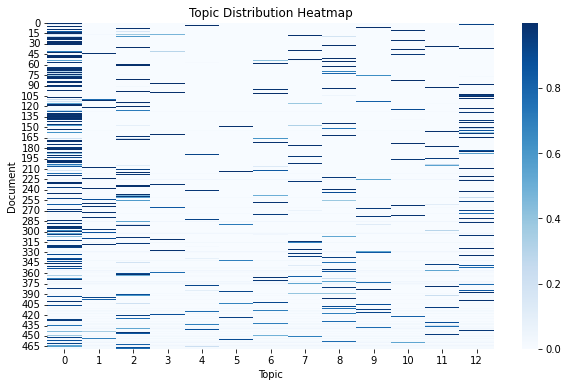

In [ ]:
topic_dist = [lda_model.get_document_topics(doc) for doc in corpus]

# Convert topic distribution to a numpy array
topic_dist_np = np.zeros((len(topic_dist), lda_model.num_topics))
for i, doc_topics in enumerate(topic_dist):
    for topic, prob in doc_topics:
        topic_dist_np[i, topic] = prob

# Generating the heatmap
fig, ax = plt.subplots(figsize=(10, 6))
sns.heatmap(topic_dist_np, cmap='Blues', ax=ax)
ax.set_xlabel('Topic')
ax.set_ylabel('Document')
ax.set_title('Topic Distribution Heatmap')
plt.show()

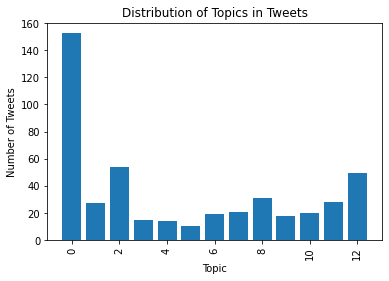

In [ ]:
topic_counts = np.sum(topic_dist_np, axis=0)
plt.bar(range(lda_model.num_topics), topic_counts)
plt.xticks(rotation=90)
plt.xlabel('Topic')
plt.ylabel('Number of Tweets')
plt.title('Distribution of Topics in Tweets')
plt.show()